In [1]:
import pandas as pd
import numpy as np
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Cropping2D
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
INPUT_SHAPE = (160,320,3)
DATA_PATH = './data'

# Load training data and split it into training and validation set

In [3]:
def load_data(data_path):
    """
    Load training data and split it into training and validation set
    """
    headers = ['center', 'left', 'right','steering','throttle','brake','speed']
    data = pd.read_csv(data_path + '/driving_log.csv', names = headers)
    
    # Use SciKit not keras splitting so it randomly selects validation set
    d_train, d_valid = train_test_split(data, test_size=0.2, random_state=42)

    return d_train, d_valid

In [4]:
def batch_generator(samples, batch_size=32, is_training=True):
    """
    Build a generator to load images as RGB
    If it is a training set include the right, left, and flipped images with steering correction
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples.iterrows():
                batch_sample = batch_sample[1]
                name = DATA_PATH + '/IMG/'+batch_sample['center'].split('/')[-1]
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                center_angle = float(batch_sample['steering'])
                images.append(center_image)
                angles.append(np.clip(center_angle,-1,1))
                if is_training:
                    # Center Flip
                    images.append(cv2.flip(center_image,1))
                    angles.append(np.clip(center_angle*-1.0,-1,1))
                    # Left
                    name = DATA_PATH + '/IMG/'+batch_sample['left'].split('/')[-1]
                    correction = 0.2
                    center_image = cv2.imread(name)
                    center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                    images.append(center_image)
                    angles.append(np.clip(center_angle+correction,-1,1))
                    # Left Flip
                    images.append(cv2.flip(center_image,1))
                    angles.append(np.clip((center_angle+correction)*-1.0,-1,1))
                    # Right
                    name = DATA_PATH + '/IMG/'+batch_sample['right'].split('/')[-1]
                    correction = -0.2
                    center_image = cv2.imread(name)
                    center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                    images.append(center_image)
                    angles.append(np.clip(center_angle+correction,-1,1))
                    # Right Flip
                    images.append(cv2.flip(center_image,1))
                    angles.append(np.clip((center_angle+correction)*-1.0,-1,1))
                    
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# Define model architecture

In [5]:
def build_model():
    """
    NVIDIA CNN model
    """
    model = Sequential()
    model.add(Cropping2D(cropping=((70,24), (60,60)), input_shape=INPUT_SHAPE))
    # Normalization
    model.add(Lambda(lambda x: x/255.0 - 0.5))
    model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary()

    return model

In [6]:
def train_model(model, train_generator, validation_generator, n_train, n_valid):
    """
    Train the model
    """
    model.compile(loss='mse', optimizer='adam')
    
    es = EarlyStopping(monitor='val_loss',\
                              min_delta=0,\
                              patience=2,\
                              verbose=0, mode='auto')
    
    history_object = model.fit_generator(train_generator, samples_per_epoch = \
            n_train, validation_data = validation_generator, \
            nb_val_samples=n_valid, nb_epoch=30, callbacks=[es])
    
    # creates a HDF5 file 'model.h5'
    model.save('model.h5')

    # plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()
    
    # delete the existing model
    del model

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 66, 200, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 66, 200, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

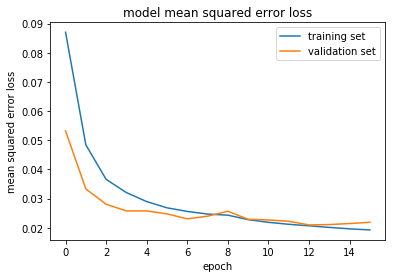

In [7]:
def main():
    """
    Run pipeline
    """
    d_train, d_valid = load_data(DATA_PATH)
    n_train = len(d_train)*2*3 # training set will expand 6x from including the right, left, and flipped images
    n_valid = len(d_valid)
    train_generator = batch_generator(d_train, batch_size=128)
    validation_generator = batch_generator(d_valid, batch_size=128, is_training=False)
    model = build_model()
    train_model(model, train_generator, validation_generator, n_train, n_valid)
if __name__ == "__main__": main()

In [8]:
d_train, d_valid = load_data(DATA_PATH)

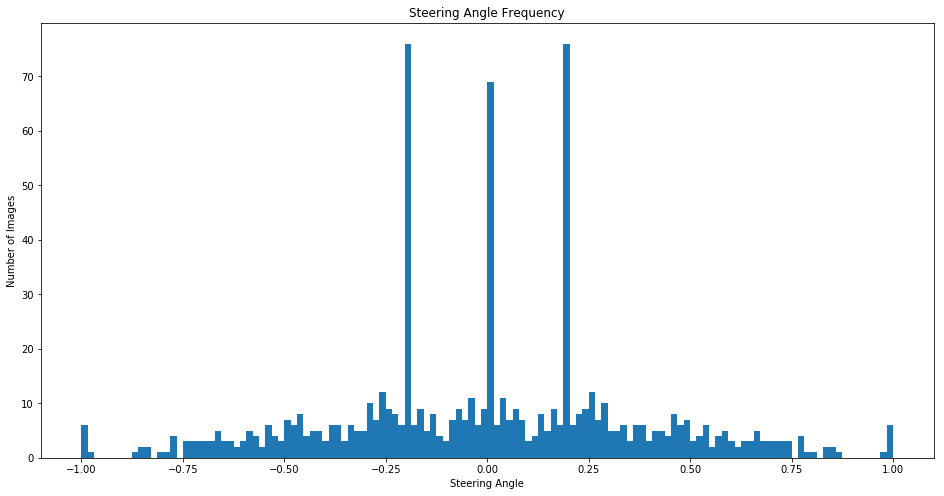

In [9]:
train_generator = batch_generator(d_train, batch_size=128)
y_train = next(train_generator)[1]
plt.figure(figsize=(16,8))
num_bins = 128
# the histogram of the data
n, bins, patches = plt.hist(y_train, num_bins)
plt.title('Steering Angle Frequency')
plt.xlabel('Steering Angle')
plt.ylabel('Number of Images')